## 1. Kinesis Analytics를 이용한 실시간 이상감지

The algorithm starts developing the machine learning model using current records in the stream when you start the application. The algorithm does not use older records in the stream for machine learning, nor does it use statistics from previous executions of the application.

In [1]:
import sys

In [2]:
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install awswrangler

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (20.2.2)


In [3]:
import json
import random
import boto3
import os
import time
import numpy as np
import pandas as pd
import awswrangler as wr

import matplotlib.pyplot as plt

%matplotlib inline 

In [4]:
kinesis_client = boto3.client('kinesis')
kinesis_analytics = boto3.client('kinesisanalytics')

In [5]:
sess = boto3.Session()

# create a s3 bucket to hold data, note that your account might already created a bucket with the same name
account_id = sess.client('sts').get_caller_identity()["Account"]
job_bucket = 's3://sagemaker-experiments-{}-{}'.format(sess.region_name, account_id)
job_bucket

's3://sagemaker-experiments-us-east-2-322537213286'

### 1.1 Input/Output Create_stream 생성

In [6]:
data_stream = ['clickstream_input', 'clickstream_output']

try:
    for stream in data_stream:
        kinesis_client.create_stream(
            StreamName=stream,
            ShardCount=1
        )
except Exception as e:
    if e.response['Error']['Code'] == 'ResourceInUseException':
        print(e.response['message'])
    else:
        print(e.response['Error']['Code'])
    

Stream clickstream_input under account 322537213286 already exists.


In [7]:
# Wait until all streams are created
result = {}
waiter = kinesis_client.get_waiter('stream_exists')
for stream in data_stream:
    waiter.wait(StreamName=stream)
    response = kinesis_client.describe_stream(StreamName=stream)
    result[stream] = response["StreamDescription"]["StreamARN"]

### 1.2 IAM 생성

In [8]:
region = boto3.Session().region_name

iam = boto3.client('iam')
sts = boto3.client('sts')

In [9]:
kinesis_role_name = 'kinesis-analytics-{}'.format(region)
kinesis_analytics_policy_name=kinesis_role_name + '_policy'
kinesis_role_name

'kinesis-analytics-us-east-2'

In [10]:
kinesis_assume_role={
  "Version": "2012-10-17",
  "Statement": [
    {
      "Effect": "Allow",
      "Principal": {
        "Service": "kinesisanalytics.amazonaws.com"
      },
      "Action": "sts:AssumeRole"
    }
  ]
}

In [11]:
kinesis_analytics_policy = {
  "Version": "2012-10-17",
  "Statement": [
    {
      "Sid": "ReadInputKinesis",
      "Effect": "Allow",
      "Action": [
        "kinesis:DescribeStream",
        "kinesis:GetShardIterator",
        "kinesis:GetRecords"
      ],
      "Resource": [
        result['clickstream_input']
      ]
    },
    {
      "Sid": "WriteOutputKinesis",
      "Effect": "Allow",
      "Action": [
        "kinesis:DescribeStream",
        "kinesis:PutRecord",
        "kinesis:PutRecords"
      ],
      "Resource": [
        result['clickstream_output']
      ]
    }
  ]
}

In [12]:
try:
    role_res = iam.create_role(
        Path='/service-role/',
        RoleName=kinesis_role_name,
        AssumeRolePolicyDocument=json.dumps(kinesis_assume_role),
    )
except Exception as e:
    if e.response['Error']['Code'] == 'EntityAlreadyExists':
        role_res = iam.get_role(
            RoleName=kinesis_role_name
        )
        print("User already exists")
    else:
        print("Unexpected error: %s" % e)

User already exists


In [13]:
try:
    policy_res = iam.create_policy(
        PolicyName=kinesis_analytics_policy_name,
        Path='/',
        PolicyDocument=json.dumps(kinesis_analytics_policy)
    )
except Exception as e:
    if e.response['Error']['Code'] == 'EntityAlreadyExists':
        PolicyArn ='arn:aws:iam::{}:policy/{}'.format(account_id, kinesis_analytics_policy_name)
        policy_res = iam.get_policy(
            PolicyArn=PolicyArn
        )
        print("User already exists")
    else:
        print("Unexpected error: %s" % e)

User already exists


In [14]:
from botocore.exceptions import ClientError

try:
    attach_res = iam.attach_role_policy(
        PolicyArn=policy_res['Policy']['Arn'],
        RoleName=kinesis_role_name
    )
    print("Policy has been succesfully attached to role: %s" % kinesis_role_name)
except Exception as e:
    print("Unexpected error: %s" % e)

Policy has been succesfully attached to role: kinesis-analytics-us-east-2


### 1.3 Create Application

In [15]:
sql_query = open('random_cut_forest_with_explanation.sql', "r").read()

In [16]:
kinesis_ApplicationName='clickstream-analytics-rcf-explanation-{}'.format(int(time.time()))

In [17]:
try:
    response = kinesis_analytics.create_application(
        ApplicationName=kinesis_ApplicationName,
        ApplicationCode=sql_query,
        Inputs=[
            {
                'NamePrefix': 'SOURCE_SQL_STREAM',
                'KinesisStreamsInput': {
                    'ResourceARN': result[data_stream[0]],
                    'RoleARN': role_res['Role']['Arn']
                },
                'InputSchema': {
                    'RecordFormat': {
                        'RecordFormatType': 'JSON',
                        'MappingParameters': {
                            'JSONMappingParameters': {
                                'RecordRowPath': '$'
                            },
                        }
                    },
                    'RecordEncoding': 'UTF-8',
                    'RecordColumns': [
                                {
                                    "SqlType": "TIMESTAMP",
                                    "Name": "TIMESTAMPS",
                                    "Mapping": "$.timestamp"
                                },
                                {
                                    "SqlType": "INTEGER",
                                    "Name": "URLS",
                                    "Mapping": "$.urls"
                                },
                                {
                                    "SqlType": "INTEGER",
                                    "Name": "USERS",
                                    "Mapping": "$.users"
                                },
                                {
                                    "SqlType": "INTEGER",
                                    "Name": "CLICKS",
                                    "Mapping": "$.clicks"
                                }
                    ],
                    "RecordFormat": {
                        "MappingParameters": {
                            'JSONMappingParameters': {
                                'RecordRowPath': '$'
                            },
                        },
                        "RecordFormatType": "JSON"
                      }
                }
            },
        ],
        Outputs=[
            {
                'Name': 'DESTINATION_SQL_STREAM',
                'DestinationSchema': {
                    'RecordFormatType': 'JSON'
                },
                "KinesisStreamsOutput": {
                    "ResourceARN": result[data_stream[1]],
                    "RoleARN": role_res['Role']['Arn']
                }
            },
        ],
    )
except Exception as e:
    if e.response['Error']['Code'] == 'ResourceInUseException':
        print(e.response['message'])
    else:
        print(e)

### 1.5 Start Application

In [18]:
response = kinesis_analytics.describe_application(
    ApplicationName=kinesis_ApplicationName
)

application = response["ApplicationDetail"]
inputId = application['InputDescriptions'][0]['InputId']

try:
    kinesis_analytics.start_application(ApplicationName=kinesis_ApplicationName,
                                     InputConfigurations=[{
                                       "Id": inputId,
                                       "InputStartingPositionConfiguration": {
                                         "InputStartingPosition": "NOW"
                                       }
                                     }])
except Exception as e:
    if e.response['Error']['Code'] == 'ResourceInUseException':
        print(e.response['message'])
    else:
        print(e.response['Error']['Code'])

In [19]:
# Wait until application starts running
response = kinesis_analytics.describe_application(
    ApplicationName=kinesis_ApplicationName
)
status = response["ApplicationDetail"]["ApplicationStatus"]

sys.stdout.write('Starting ')
while status != "RUNNING":
    sys.stdout.write('.')
    sys.stdout.flush()
    time.sleep(1)
    response = kinesis_analytics.describe_application(
      ApplicationName=kinesis_ApplicationName
    )
    status = response["ApplicationDetail"]["ApplicationStatus"]
sys.stdout.write('RUNNING')
sys.stdout.write(os.linesep)

Starting .................................RUNNING


###  1.7 Sending Input Stream

In [20]:
%store -r

In [21]:
resampling_clickstream = filtered_clickstream.set_index('timestamp').resample('1T')
training_data = resampling_clickstream.nunique()[['url','user_session_id']]
training_data['clicks'] = resampling_clickstream.count()['clickstream_id']
training_data.columns = ['urls','users','clicks']
training_data.head()

,urls,users,clicks
timestamp,,,
2012-03-01 00:00:00,3,4,5
2012-03-01 00:01:00,2,3,4
2012-03-01 00:02:00,1,4,4
2012-03-01 00:03:00,4,4,5
2012-03-01 00:04:00,5,6,9


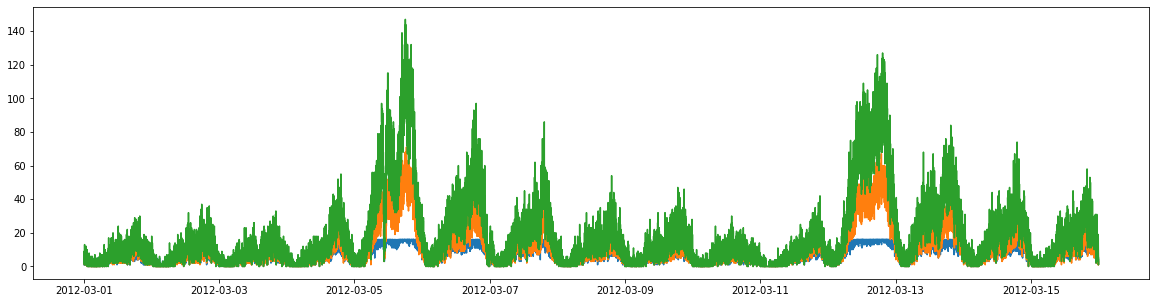

In [22]:
plt.figure(figsize=(20,5))
plt.plot(training_data)
plt.show()

In [23]:
training_data = training_data.reset_index()
col_names = training_data.keys().to_list()
col_names

['timestamp', 'urls', 'users', 'clicks']

In [24]:
def s3_sink(shardIterator):
    rows = []
    response = kinesis_client.get_records(ShardIterator=shardIterator)
    records = response["Records"]

    try:
        while len(records) > 0:
            parsed_records = []
            for rec in records:
                parsed_record = json.loads(rec["Data"])
                parsed_records.append(parsed_record)
            rows.extend(parsed_records)
            time.sleep(1)
            shardIterator = response["NextShardIterator"]
            response = kinesis_client.get_records(ShardIterator=shardIterator)
            records = response["Records"]
        flag = rows[0]['TIMESTAMPS'].replace(":","-").replace(" ","-").replace(".","-")
        s3_save_path = '{}/{}/{}'.format(job_bucket, 'kinesis-analytics', flag)
        wr.s3.to_csv(
            df=pd.DataFrame(rows),
            path=s3_save_path
        )
    except:
        sys.stdout.write("[ExpiredIteratorException] Iterator expired.")
        pass
    return rows

In [25]:
def make_kinesis_data(df, i, col_names):
    kinesis_data = {}
    kinesis_data['timestamp']=str(df['timestamp'][i])
    for col_name in col_names:
        if col_name not in ['timestamp']:
            kinesis_data[col_name]=int(df.iloc[i][col_name])
    return kinesis_data

In [26]:
response = kinesis_client.describe_stream(StreamName=data_stream[1])
shardId = response["StreamDescription"]["Shards"][0]["ShardId"]
response = kinesis_client.get_shard_iterator(StreamName=data_stream[1],
                                    ShardId=shardId,
                                    ShardIteratorType="LATEST")
shardIterator = response["ShardIterator"]

kinesis_data = {}
rnd=random.random()

In [27]:
response = kinesis_client.describe_stream(StreamName=data_stream[1])
shardId = response["StreamDescription"]["Shards"][0]["ShardId"]
shard_response = kinesis_client.get_shard_iterator(StreamName=data_stream[1],
                                    ShardId=shardId,
                                    ShardIteratorType="LATEST")
shardIterator = shard_response["ShardIterator"]

result = []
rnd=random.random()

for idx in training_data.index:
    kinesis_data = json.dumps(make_kinesis_data(training_data, idx, col_names))
    kinesis_client.put_record(
        StreamName=data_stream[0],
        Data=kinesis_data,
        PartitionKey=str(rnd)
    )
    if idx%10000 == 0:
        time.sleep(3)
        result.extend(s3_sink(shardIterator))
        shard_response = kinesis_client.get_shard_iterator(StreamName=data_stream[1],
                                    ShardId=shardId,
                                    ShardIteratorType="LATEST")
        shardIterator = shard_response["ShardIterator"]
time.sleep(3)
result.extend(s3_sink(shardIterator))

In [28]:
len(result)

21600

In [29]:
from datetime import datetime

revised_result = []
for row in result:
    result_row = {}
    result_row['TIMESTAMPS'] = datetime.strptime(row['TIMESTAMPS'].split('.')[0],'%Y-%m-%d %H:%M:%S')
    result_row['URLS'] = row['URLS']
    result_row['USERS'] = row['USERS']
    result_row['CLICKS'] = row['CLICKS']
    result_row['ANOMALY_SCORE'] = row['ANOMALY_SCORE']
    
    anomaly_exp = json.loads(row['ANOMALY_EXPLANATION'])
    result_row['URLS_STRENGTH'] = float(anomaly_exp['URLS']['STRENGTH'])
    result_row['URLS_ATTRIBUTION_SCORE'] = float(anomaly_exp['URLS']['STRENGTH'])
    result_row['USERS_STRENGTH'] = float(anomaly_exp['USERS']['STRENGTH'])
    result_row['USERS_ATTRIBUTION_SCORE'] = float(anomaly_exp['USERS']['ATTRIBUTION_SCORE'])
    result_row['CLICKS_STRENGTH'] = float(anomaly_exp['CLICKS']['STRENGTH'])
    result_row['CLICKS_ATTRIBUTION_SCORE'] = float(anomaly_exp['CLICKS']['ATTRIBUTION_SCORE'])
    revised_result.append(result_row)

In [30]:
training_data = training_data.set_index('timestamp')

In [31]:
result_data = pd.DataFrame(revised_result)
result_data = result_data.sort_values(by=['TIMESTAMPS'])
result_data = result_data.set_index('TIMESTAMPS')
result_data.head(5)

,URLS,USERS,CLICKS,ANOMALY_SCORE,URLS_STRENGTH,URLS_ATTRIBUTION_SCORE,USERS_STRENGTH,USERS_ATTRIBUTION_SCORE,CLICKS_STRENGTH,CLICKS_ATTRIBUTION_SCORE
TIMESTAMPS,,,,,,,,,,
2012-03-01 00:00:00,3,4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-03-01 00:01:00,2,3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-03-01 00:02:00,1,4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-03-01 00:03:00,4,4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-03-01 00:04:00,5,6,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88182bad30>]],
      dtype=object)

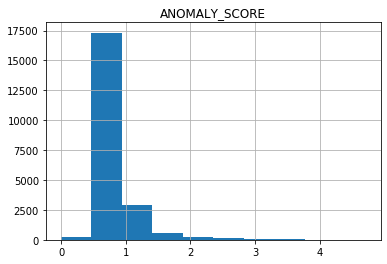

In [32]:
results_pd = pd.DataFrame(result_data['ANOMALY_SCORE'])
results_pd.hist()

In [33]:
from sklearn.preprocessing import MinMaxScaler
import copy

normalized_result_data = copy.deepcopy(result_data)
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(normalized_result_data) 
normalized_result_data.loc[:,:] = scaled_values

In [34]:
threshold = 1.4

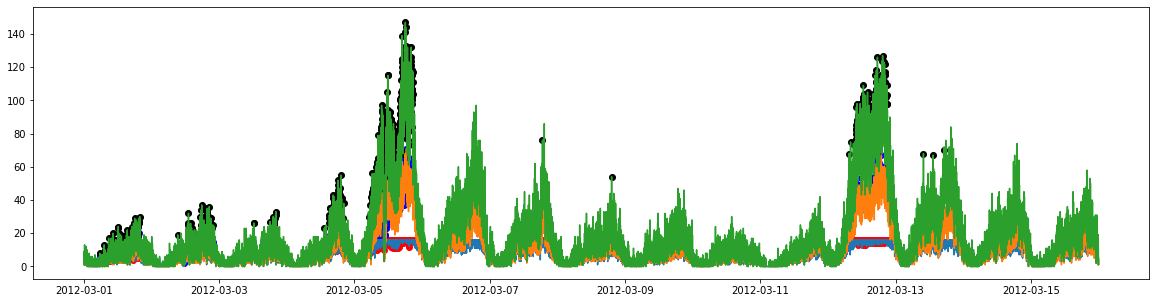

In [35]:
plt.figure(figsize=(20,5))
plt.plot(result_data[['URLS','USERS','CLICKS']])

anomalous = result_data[list((results_pd > threshold)['ANOMALY_SCORE'])]
plt.scatter(x= anomalous.index, y=anomalous['URLS'].values, c='red')
plt.scatter(x= anomalous.index, y=anomalous['USERS'].values, c='blue')
plt.scatter(x= anomalous.index, y=anomalous['CLICKS'].values, c='black')
plt.show()

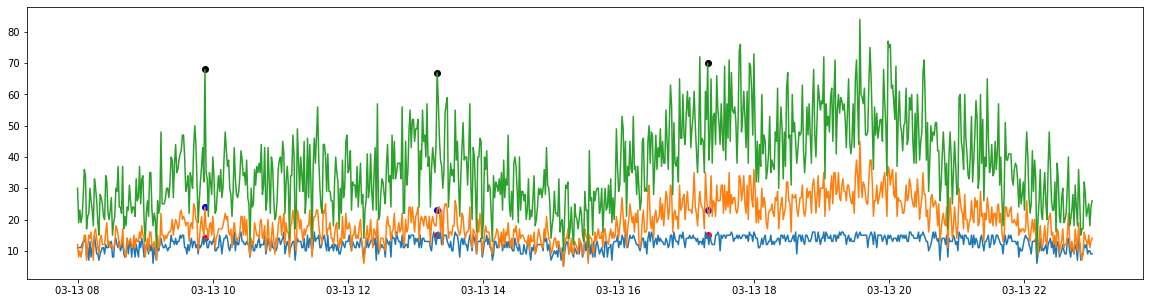

In [36]:
plt.figure(figsize=(20,5))
plt.plot(result_data[['URLS','USERS','CLICKS']]["2012-03-13 08:00:00":"2012-03-13 23:00:00"])

anomalous = result_data[list((results_pd > threshold)['ANOMALY_SCORE'])]["2012-03-13 08:00:00":"2012-03-13 23:00:00"]
plt.scatter(x= anomalous.index, y=anomalous['URLS'].values, c='red')
plt.scatter(x= anomalous.index, y=anomalous['USERS'].values, c='blue')
plt.scatter(x= anomalous.index, y=anomalous['CLICKS'].values, c='black')
plt.show()

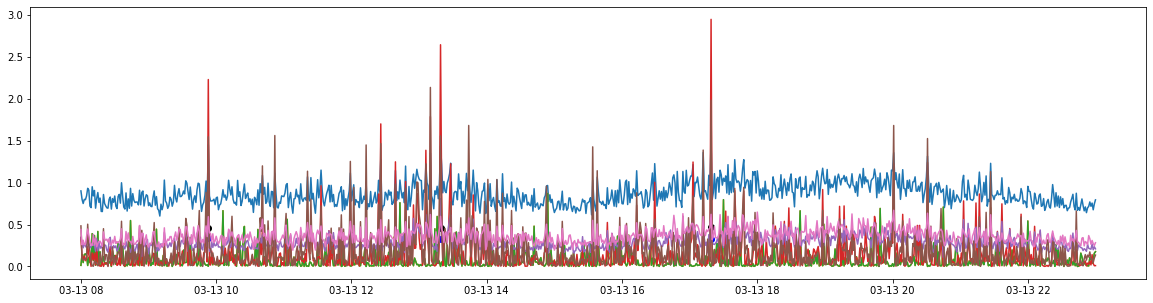

In [37]:
plt.figure(figsize=(20,5))
plt.plot(result_data[['ANOMALY_SCORE','URLS_STRENGTH','URLS_ATTRIBUTION_SCORE','USERS_STRENGTH','USERS_ATTRIBUTION_SCORE','CLICKS_STRENGTH','CLICKS_ATTRIBUTION_SCORE']]["2012-03-13 08:00:00":"2012-03-13 23:00:00"])

anomalous = normalized_result_data[list((results_pd > threshold)['ANOMALY_SCORE'])]["2012-03-13 08:00:00":"2012-03-13 23:00:00"]
plt.scatter(x= anomalous.index, y=anomalous['USERS'].values, c='blue')
plt.scatter(x= anomalous.index, y=anomalous['CLICKS'].values, c='black')
plt.show()

In [38]:
high_anomaly=result_data["2012-03-13 08:00:00":"2012-03-13 23:00:00"]
high_anomaly.sort_values(by=['ANOMALY_SCORE'], ascending=False).head(5)

,URLS,USERS,CLICKS,ANOMALY_SCORE,URLS_STRENGTH,URLS_ATTRIBUTION_SCORE,USERS_STRENGTH,USERS_ATTRIBUTION_SCORE,CLICKS_STRENGTH,CLICKS_ATTRIBUTION_SCORE
TIMESTAMPS,,,,,,,,,,
2012-03-13 17:19:00,15,23,70,1.501229,0.0000,0.0000,2.9491,0.8520,1.9846,0.6222
2012-03-13 09:53:00,14,24,68,1.453114,0.0023,0.0023,2.2307,0.7973,1.5472,0.5938
2012-03-13 13:19:00,15,23,67,1.437916,0.0003,0.0003,2.6460,0.8097,1.5575,0.5976
2012-03-13 17:12:00,13,29,72,1.359988,0.0573,0.0573,0.9466,0.5399,1.3888,0.5955
2012-03-13 20:01:00,15,31,76,1.357581,0.0007,0.0007,1.2297,0.6382,1.6823,0.6708


In [39]:
kinesis_analytics.stop_application(ApplicationName=kinesis_ApplicationName)

# Wait until application stops running
response = kinesis_analytics.describe_application(
    ApplicationName=kinesis_ApplicationName
)
status = response["ApplicationDetail"]["ApplicationStatus"]
sys.stdout.write('Stopping ')

while status != "READY":
    sys.stdout.write('.')
    sys.stdout.flush()
    time.sleep(1)
    response = kinesis_analytics.describe_application(
        ApplicationName=kinesis_ApplicationName
    )
    status = response["ApplicationDetail"]["ApplicationStatus"]

sys.stdout.write(os.linesep)

Stopping ....


In [40]:
kinesis_analytics.delete_application(ApplicationName=kinesis_ApplicationName,
                                     CreateTimestamp=response['ApplicationDetail']['CreateTimestamp'])

{'ResponseMetadata': {'RequestId': 'c9ccb1c3-2108-4773-b989-7c308f6c57fa',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c9ccb1c3-2108-4773-b989-7c308f6c57fa',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'date': 'Sat, 22 Aug 2020 00:41:25 GMT'},
  'RetryAttempts': 0}}